In [49]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, GlobalAveragePooling1D, GlobalAveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_hub as hub
#import tensorflow_text

In [4]:
df = pd.read_csv('spam.csv',encoding='ANSI')
display(df.head())

df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


_v1 : ham or spam_

In [5]:
cols = ['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

df['text'] = df.apply(lambda row: ' '.join(row[cols].dropna().astype(str)), axis=1)
df.drop(cols, axis=1, inplace=True)
df.head()

,v1,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df_sum = df.groupby(["v1"])['v1'].count().reset_index(name='count')

df_sum.head()

,v1,count
0,ham,4825
1,spam,747


In [7]:
df_sum.iloc[0]['count'] / df_sum.iloc[1]['count'] * 100

np.float64(645.9170013386881)

In [8]:
df_sum["percentage"] = round((df_sum["count"] / df_sum["count"].sum()) * 100, 2)
df_sum

,v1,count,percentage
0,ham,4825,86.59
1,spam,747,13.41


In [9]:
fig = px.bar(df_sum, x='v1', y='count', title='Nombre d\'occurrences de ham et spam', color='v1')

fig.show()

On peut observer une _imbalanced_

## Preprocessing

In [10]:
df['v1'] = df.v1.map({'ham':0,'spam':1})
df['text_clean'] = df['text'].str.replace(r"[\W_]+", " ",regex=True)
df['text_clean'] = df['text_clean'].fillna('').apply(lambda x: x.lower())

df

,v1,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5568,0,Will ÃŒ_ b going to esplanade fr home?,will ãœ b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other suggest...
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i d...


In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.text_clean, df.v1, test_size=0.1, random_state=33, stratify=df.v1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=33, stratify=y_train)

In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x_train)

train_encoded = tokenizer.texts_to_sequences(x_train)
test_encoded = tokenizer.texts_to_sequences(x_test)
val_encoded = tokenizer.texts_to_sequences(x_val)

In [45]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_encoded, padding="post")
train_pad.shape

(4512, 190)

In [14]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_encoded, padding="post")
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_encoded, padding="post", maxlen=len(train_pad[0]))
val_pad = tf.keras.preprocessing.sequence.pad_sequences(val_encoded, padding="post", maxlen=len(train_pad[0]))

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((train_pad, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((test_pad, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((val_pad, y_val))

train_ds = train_ds.shuffle(len(train_ds)).batch(64)
test_ds = test_ds.shuffle(len(test_ds)).batch(64)
val_ds = val_ds.shuffle(len(val_ds)).batch(64)

In [ ]:
# check du contenu d'un batch

for review, star in train_ds.take(1):
  print(review, star)

tf.Tensor(
[[ 28   1  30 ...   0   0   0]
 [  6  61  98 ...   0   0   0]
 [326 746 245 ...   0   0   0]
 ...
 [  1  55 719 ...   0   0   0]
 [  3  23   4 ...   0   0   0]
 [256  39  51 ...   0   0   0]], shape=(64, 190), dtype=int32) tf.Tensor(
[0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0], shape=(64,), dtype=int64)


In [57]:
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True ,
        verbose=1
)

## Baseline

### Embedding simple

Modèles testés :

* 3 couches Dense avec 20 epochs:
    * Couche de prédiction avec sigmoid : ```Epoch 12: early stopping Restoring model weights from the end of the best epoch: 7.```, f1 macro avg = 0.97
    * Couche de prédiction avec softmax : ```Restoring model weights from the end of the best epoch: 16.```, f1 macro avg = 0.98
* 5 couches Dense avec 30 epochs, car 20 était la meilleure:
    * Couche de prédiction avec sigmoid : ```Epoch 23: early stopping Restoring model weights from the end of the best epoch: 18.```, f1 macro avg = 0.98
    * Couche de prédiction avec softmax : ```Epoch 24: early stopping Restoring model weights from the end of the best epoch: 19.```, f1 macro avg = 0.98


Modèle conservé : 3 couches softmax, meme score que les 5 couches, mais moins d'epochs et plus rapide.

In [77]:
# A GARDER

output_dim = 128
vocab_size = len(tokenizer.word_counts)
len_texts = train_pad.shape[1]

model_embedding = Sequential()
model_embedding.add(Embedding(input_dim=vocab_size + 1, output_dim=output_dim, name="embedding")) # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
model_embedding.add(GlobalAveragePooling1D())
# along each dimension of the representation space.
model_embedding.add(Dense(len_texts, activation='relu')) # a dense layer
model_embedding.add(Dense(80, activation='relu')) # a dense layer
model_embedding.add(Dense(20, activation='relu')) # a dense layer
model_embedding.add(Dense(2, activation='softmax')) # the prediction layer

model_embedding.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [78]:
history = model_embedding.fit(
    train_ds,
    validation_data=test_ds,
    #class_weight=d_cat,
    callbacks=[early_stopping],
    epochs=20)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4356 - sparse_categorical_accuracy: 0.8632 - val_loss: 0.3824 - val_sparse_categorical_accuracy: 0.8656
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3742 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.3704 - val_sparse_categorical_accuracy: 0.8656
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3546 - sparse_categorical_accuracy: 0.8698 - val_loss: 0.2922 - val_sparse_categorical_accuracy: 0.8656
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2831 - sparse_categorical_accuracy: 0.8834 - val_loss: 0.1132 - val_sparse_categorical_accuracy: 0.9570
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9530 - val_loss: 0.1802 - val_sparse_categorical_accuracy: 0.9032
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.0555 - val_sparse_categorical_accuracy: 0.9839
Epoch 7/20

In [59]:
model_embedding.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 190, 128)       │     1,012,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 190)            │        24,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 80)             │        15,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 20)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,163,334 (12.07 MB)

 Trainable params: 1,054,444 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,108,890 (8.04 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


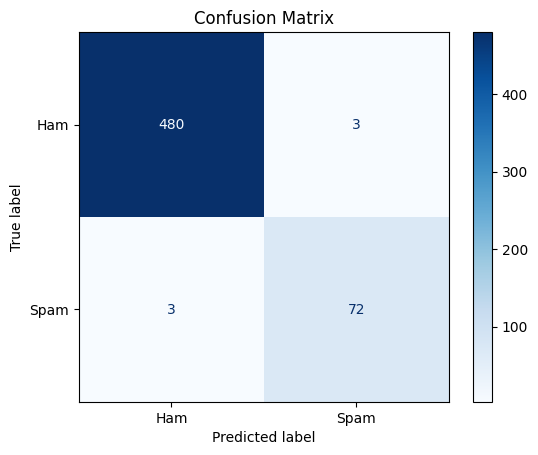

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       483
           1       0.96      0.96      0.96        75

    accuracy                           0.99       558
   macro avg       0.98      0.98      0.98       558
weighted avg       0.99      0.99      0.99       558



In [79]:
# Evaluate the Model
predictions = model_embedding.predict(test_pad)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))

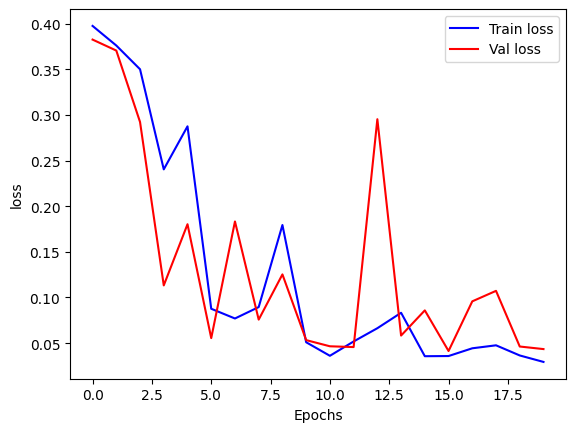

In [80]:
plt.plot(history.history["loss"], color="b", label='Train loss')
plt.plot(history.history["val_loss"], color="r", label='Val loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

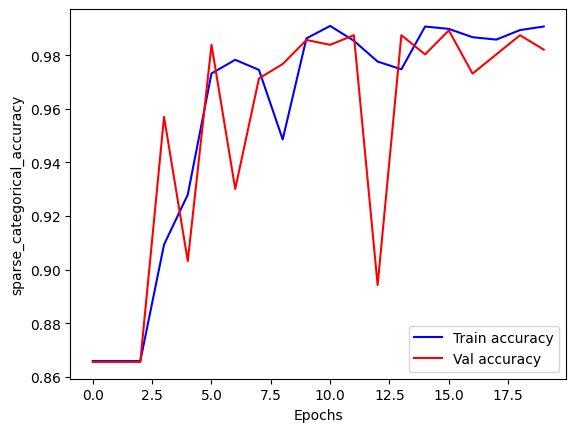

In [81]:
plt.plot(history.history["sparse_categorical_accuracy"], color="b", label='Train accuracy')
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r", label='Val accuracy')
plt.ylabel("sparse_categorical_accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [82]:
model_embedding.save('./model/model_embedding.keras')

-------------------------------

In [72]:
output_dim = 128
vocab_size = len(tokenizer.word_counts)
len_texts = train_pad.shape[1]

model_embedding_5 = Sequential()
model_embedding_5.add(Embedding(input_dim=vocab_size + 1, output_dim=output_dim, name="embedding"))
model_embedding_5.add(GlobalAveragePooling1D())
model_embedding_5.add(Dense(len_texts, activation='relu'))  # première couche dense
model_embedding_5.add(Dense(80, activation='relu'))        # deuxième couche dense
model_embedding_5.add(Dense(60, activation='relu'))        # troisième couche dense
model_embedding_5.add(Dense(40, activation='relu'))        # quatrième couche dense
model_embedding_5.add(Dense(20, activation='relu'))        # cinquième couche dense
model_embedding_5.add(Dense(2, activation='sigmoid'))      # couche de prédiction

model_embedding_5.compile(optimizer='adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [74]:
history5 = model_embedding_5.fit(
    train_ds,
    validation_data=test_ds,
    #class_weight=d_cat,
    callbacks=[early_stopping],
    epochs=30)

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0336 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0531 - val_sparse_categorical_accuracy: 0.9821
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.0532 - val_sparse_categorical_accuracy: 0.9892
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.0579 - val_sparse_categorical_accuracy: 0.9875
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0430 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.0452 - val_sparse_categorical_accuracy: 0.9875
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0356 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0701 - val_sparse_categorical_accuracy: 0.9803
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0345 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.0474 - val_sparse_categorical_accuracy: 0.9875
Epoch 7/30

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


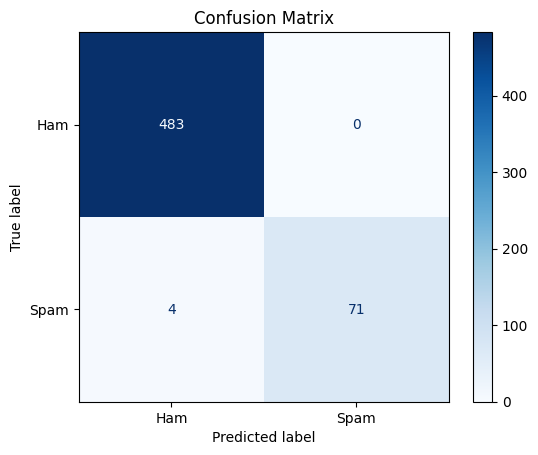

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       1.00      0.95      0.97        75

    accuracy                           0.99       558
   macro avg       1.00      0.97      0.98       558
weighted avg       0.99      0.99      0.99       558



In [75]:
# Evaluate the Model
predictions = model_embedding_5.predict(test_pad)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))

----------------------------------------

### SimpleRNN

In [17]:
model = Sequential()
model.add(Input(shape=(190, 1)))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,009 (105.50 KB)

 Trainable params: 27,009 (105.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - binary_accuracy: 0.8705 - loss: 0.6022 - val_binary_accuracy: 0.8665 - val_loss: 0.3951
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - binary_accuracy: 0.8687 - loss: 0.3904 - val_binary_accuracy: 0.8665 - val_loss: 0.3928
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - binary_accuracy: 0.8663 - loss: 0.3943 - val_binary_accuracy: 0.8665 - val_loss: 0.3934
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - binary_accuracy: 0.8609 - loss: 0.4041 - val_binary_accuracy: 0.8665 - val_loss: 0.3945
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - binary_accuracy: 0.8593 - loss: 0.4090 - val_binary_accuracy: 0.8665 - val_loss: 0.3931
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - binary_accuracy: 0.8715 - loss: 0.3849 - val_binary_accuracy: 0.8665 - val_loss: 0.3945
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - binary_accuracy: 0.8587 - loss: 0.4116 - val_binary_accuracy: 0.8665 - val_loss: 0.3931
Epoch 8/10
71

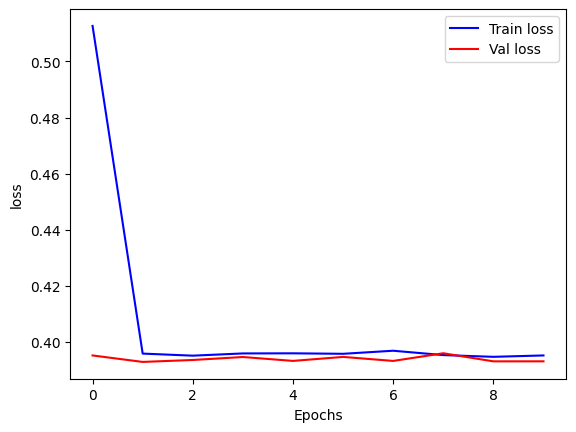

In [19]:
plt.plot(history.history["loss"], color="b", label='Train loss')
plt.plot(history.history["val_loss"], color="r", label='Val loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

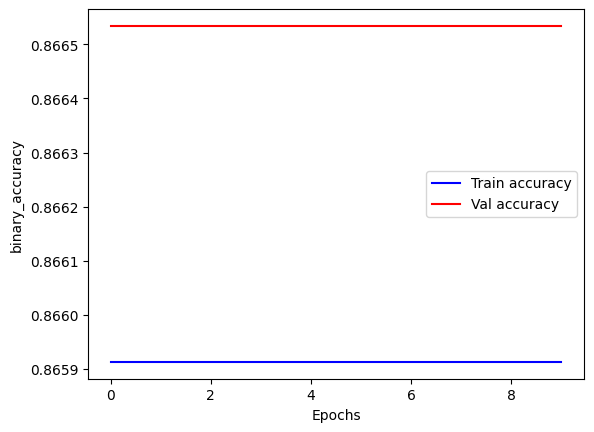

In [20]:
plt.plot(history.history["binary_accuracy"], color="b", label='Train accuracy')
plt.plot(history.history["val_binary_accuracy"], color="r", label='Val accuracy')
plt.ylabel("binary_accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [21]:
loss, acc = model.evaluate(test_ds, verbose=2)
print("accuracy: {:5.2f}%".format(100 * acc))

9/9 - 0s - 10ms/step - binary_accuracy: 0.8656 - loss: 0.3947
accuracy: 86.56%


In [22]:
predictions = model.predict(test_pad)
predictions = predictions.reshape(-1)
results = pd.DataFrame({'test':y_test,'pred':predictions})
results['pred'] = round(results['pred'])
print(classification_report(results.test, results.pred))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       483
           1       0.00      0.00      0.00        75

    accuracy                           0.87       558
   macro avg       0.43      0.50      0.46       558
weighted avg       0.75      0.87      0.80       558



c:\Users\DELL\Documents\Formation_Jedha\Project\AT-T_spam_detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\DELL\Documents\Formation_Jedha\Project\AT-T_spam_detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\DELL\Documents\Formation_Jedha\Project\AT-T_spam_detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



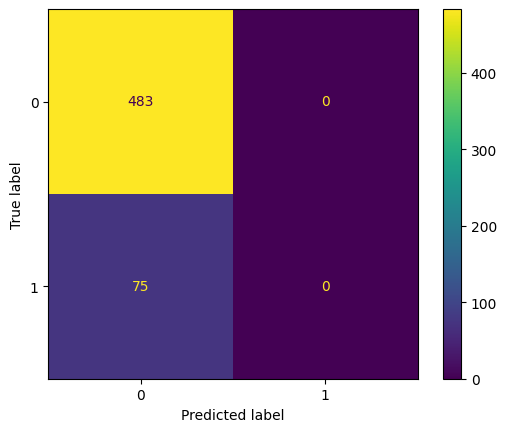

In [23]:
cm_test = confusion_matrix(results.test, results.pred)
ConfusionMatrixDisplay(cm_test).plot()
plt.show()

## Transfert Learning - BERT